In [1]:
import keras
from keras.datasets import cifar10
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas
import seaborn as sns

# CIFAR-10 Dataset

In [7]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

train_size = x_train.shape[0]
test_size = x_test.shape[0]
print(f'Train size = {train_size}')
print(f'Test size = {test_size}')

print('')

input_dimensions = x_train.shape[1:]
output_dimensions = y_train.shape[1:]
print(f'Input dimensions = {input_dimensions}') 
print(f'Output dimensions = {output_dimensions}')

print('')

# Output labels defined at https://www.cs.toronto.edu/~kriz/cifar.html
labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog', 
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
print(f'Output labels = {output_labels}')

Train size = 50000
Test size = 10000

Input dimensions = (32, 32, 3)
Output dimensions = (1,)

Output labels = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


# Data Distribution

/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


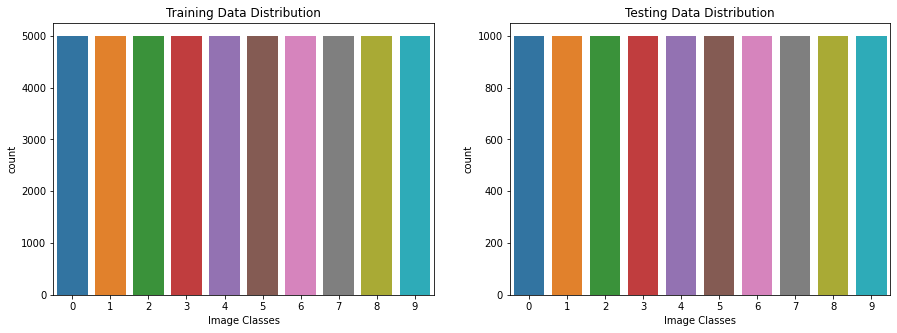

In [8]:
_, axes = plt.subplots(1,2,figsize=(15,5)) 

sns.countplot(y_train.ravel(), ax=axes[0])
axes[0].set_title('Training Data Distribution')
axes[0].set_xlabel('Image Classes')

# Count plot for testing set
sns.countplot(y_test.ravel(), ax=axes[1])
axes[1].set_title('Testing Data Distribution')
axes[1].set_xlabel('Image Classes')
plt.show()

# Mean Images

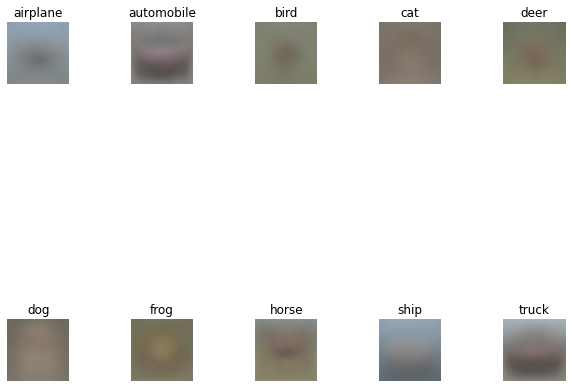

In [30]:
def plot_images_per_class(data_map):
    R, C = 2, 5
    fig, axes = plt.subplots(R, C, figsize=(10,10))
    axes = axes.ravel()
    for i in range(R*C):
        axes[i].imshow(mean_train_images[i].astype(np.uint8))
        axes[i].set_title(f'{labels[i]}')
        axes[i].axis('off')
        plt.subplots_adjust(wspace=1)

def get_mean_image(x_train, label):
    images = np.array([x for x, l in zip(x_train, y_train) if l == label])
    return np.mean(images, axis=0)

mean_train_images = {label: get_mean_image(x_train, label) for label in labels}
plot_images(mean_train_images)
# print(mean_train_images)

# Class Standard Deviations

In [33]:
def get_std_image(x_train, label):
    images = np.array([x for x, l in zip(x_train, y_train) if l == label])
    return np.std(images, axis=0)

std_train_images = {label: get_std_image(x_train, label) for label in labels}
# plot_images(std_train_images)
print(std_train_images)

{0: array([[[68.64587966, 61.61765186, 62.46642654],
        [67.94507911, 60.83254119, 61.83811453],
        [67.85732895, 60.61181656, 61.73449322],
        ...,
        [68.21923101, 60.80792538, 61.89847674],
        [68.26188657, 60.96684985, 61.91286212],
        [68.67116466, 61.54178736, 62.42617171]],

       [[68.19556633, 61.17614284, 62.61276744],
        [67.66747086, 60.62850316, 62.28219536],
        [67.63965683, 60.48554865, 62.15011928],
        ...,
        [67.66254825, 60.27784645, 62.00602008],
        [67.74607465, 60.46246496, 61.93626194],
        [68.19589357, 61.13555091, 62.41696192]],

       [[67.81179013, 60.80587186, 62.68808491],
        [67.19592751, 60.24507773, 62.49415649],
        [66.94936487, 59.94261735, 62.18207896],
        ...,
        [66.84769343, 59.84428816, 62.0741907 ],
        [67.02940572, 60.07286955, 62.11641438],
        [67.56358117, 60.61797455, 62.33534595]],

       ...,

       [[65.92285956, 63.68093996, 71.18663479],
       

# Class Variances

In [34]:
def get_var_image(x_train, label):
    images = np.array([x for x, l in zip(x_train, y_train) if l == label])
    return np.var(images, axis=0)

var_train_images = {label: get_var_image(x_train, label) for label in labels}
# plot_images(var_train_images)
print(var_train_images)

{0: array([[[4712.25679424, 3796.73502044, 3902.05444464],
        [4616.533775  , 3700.59806784, 3823.95240924],
        [4604.61709276, 3673.79230656, 3811.14765296],
        ...,
        [4653.86347964, 3697.60378944, 3831.42142236],
        [4659.68515776, 3716.95678044, 3833.20249596],
        [4715.72885616, 3787.391591  , 3897.02691484]],

       [[4650.63526704, 3742.52045276, 3920.35864636],
        [4578.88661244, 3675.81539516, 3879.07185904],
        [4575.12317616, 3658.501596  , 3862.63732656],
        ...,
        [4578.22043504, 3633.41877296, 3844.74652636],
        [4589.53063104, 3655.70966844, 3836.10054336],
        [4650.6799    , 3737.55558556, 3895.87713584]],

       [[4598.43888124, 3697.35405296, 3929.79599024],
        [4515.29267376, 3629.469391  , 3905.519596  ],
        [4482.21745664, 3593.117375  , 3866.610944  ],
        ...,
        [4468.61411644, 3581.33882496, 3853.205151  ],
        [4492.941231  , 3608.74965596, 3858.44893596],
        [4564.8375

# Class Contrasts

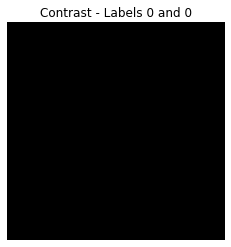

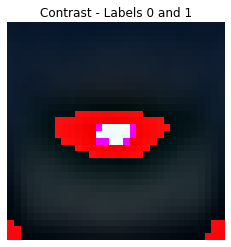

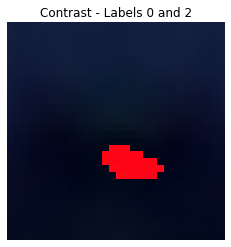

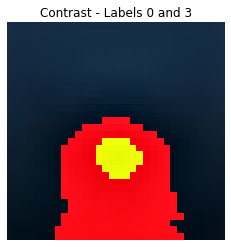

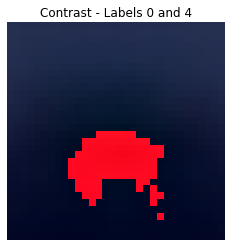

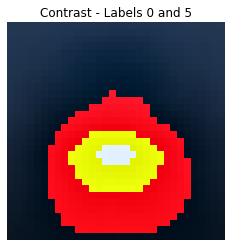

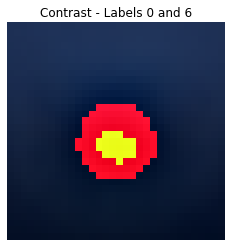

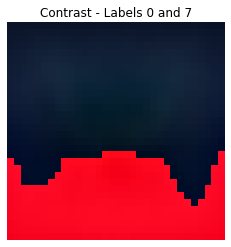

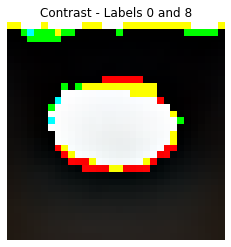

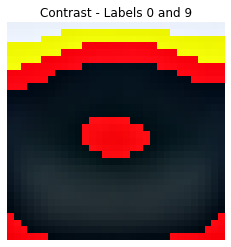

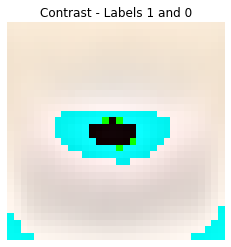

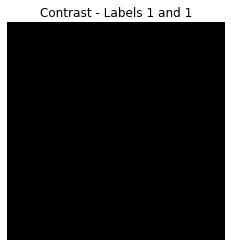

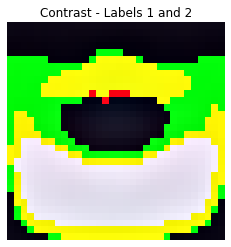

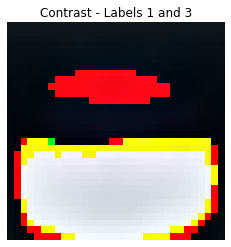

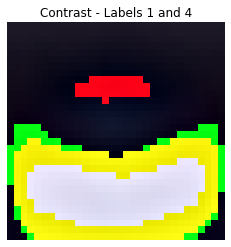

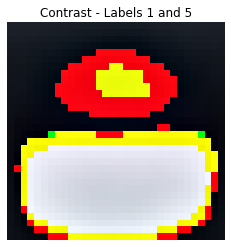

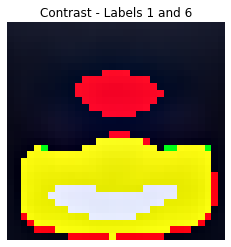

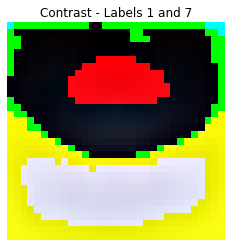

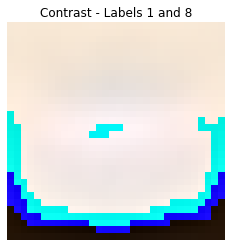

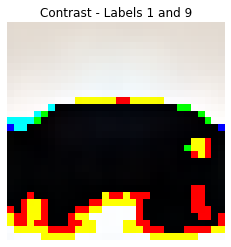

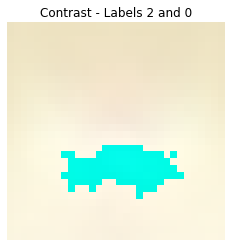

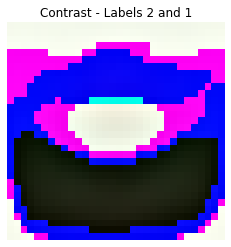

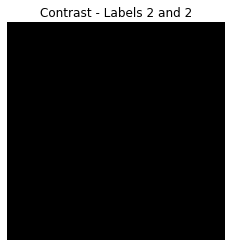

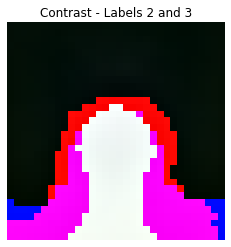

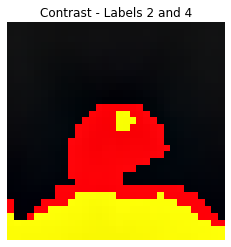

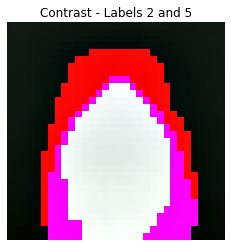

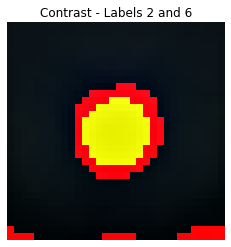

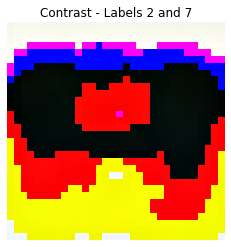

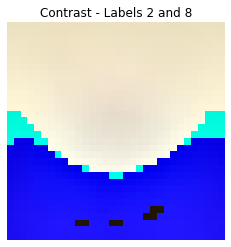

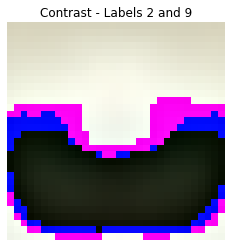

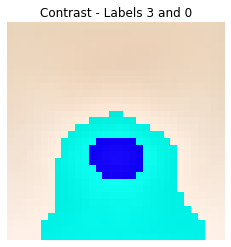

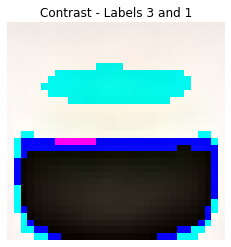

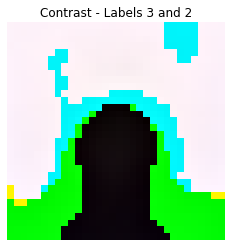

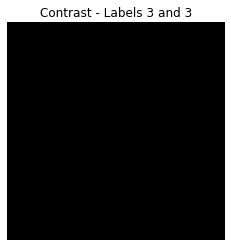

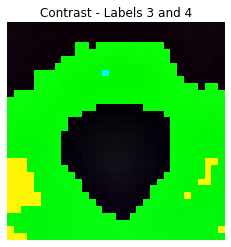

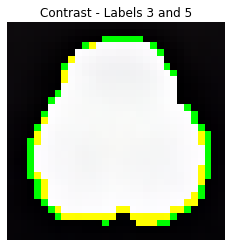

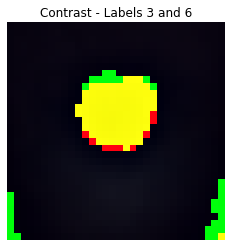

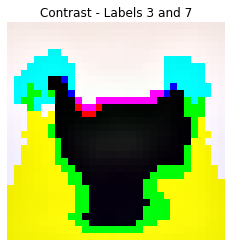

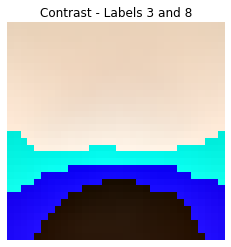

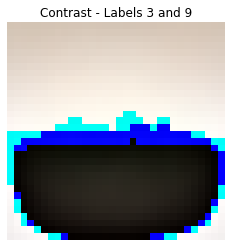

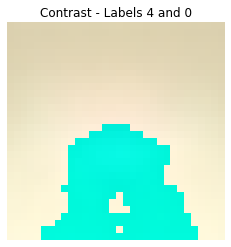

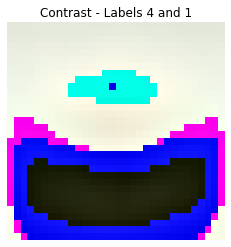

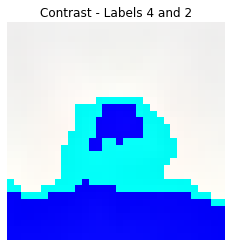

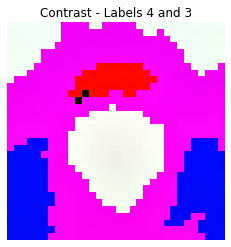

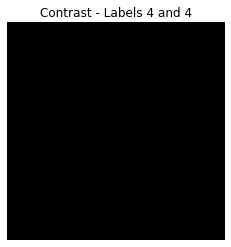

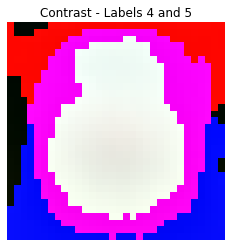

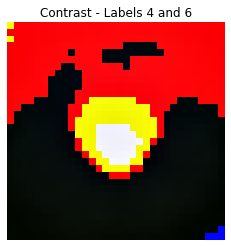

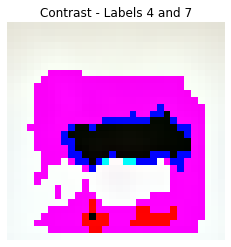

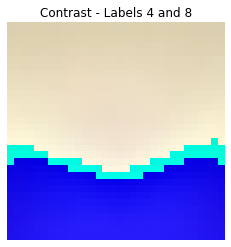

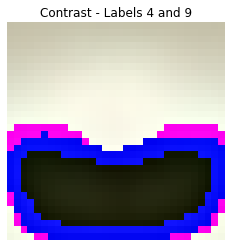

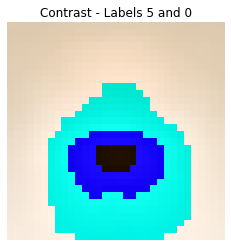

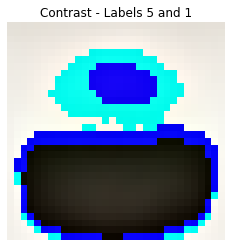

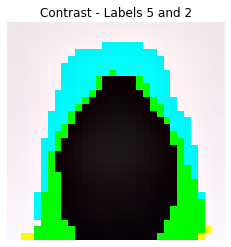

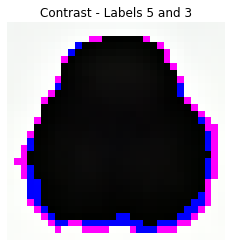

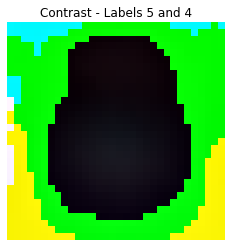

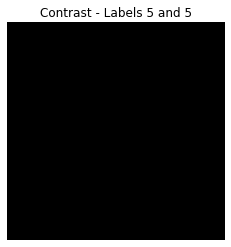

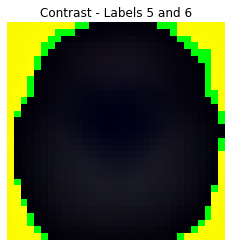

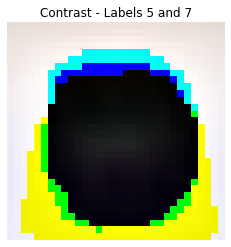

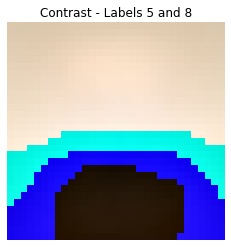

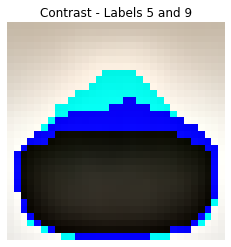

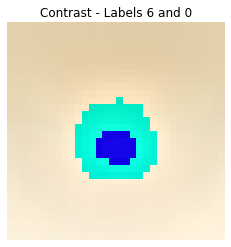

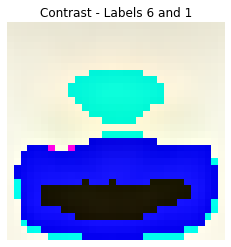

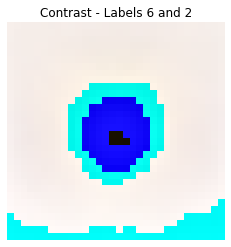

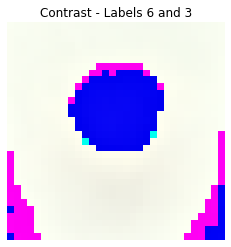

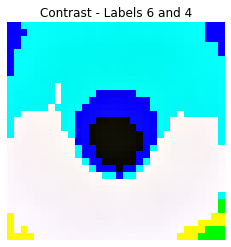

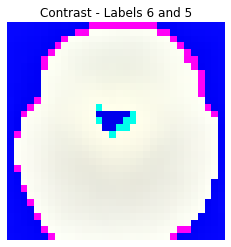

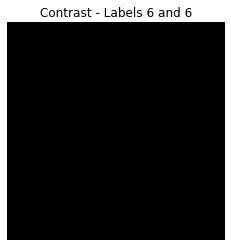

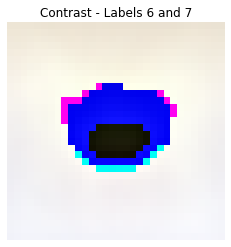

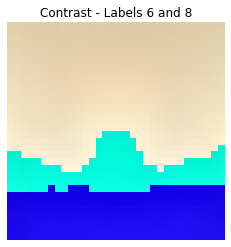

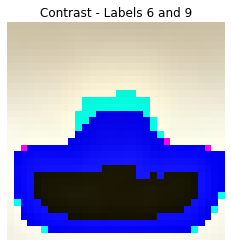

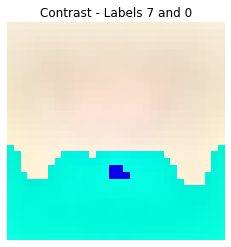

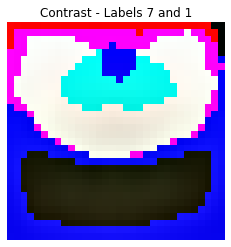

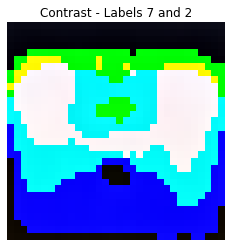

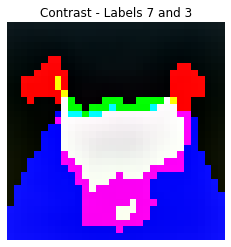

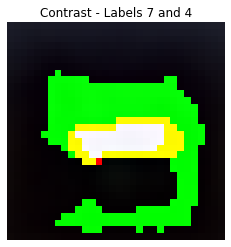

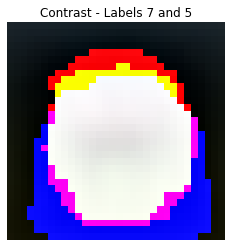

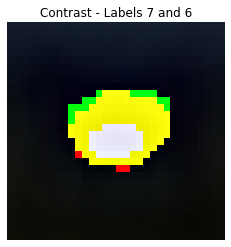

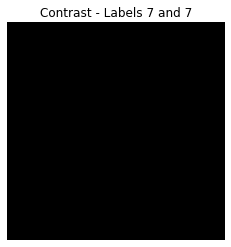

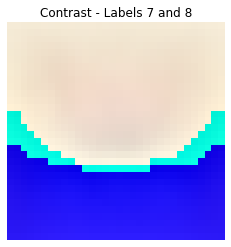

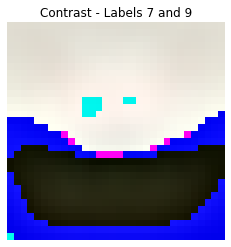

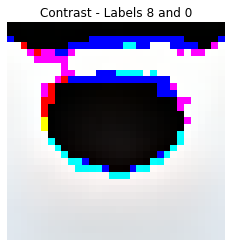

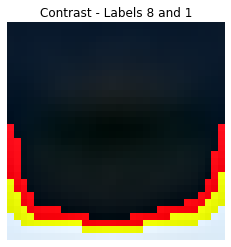

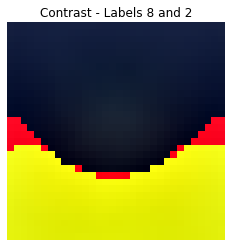

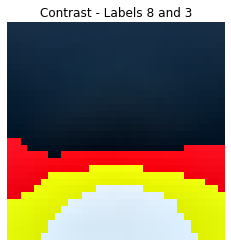

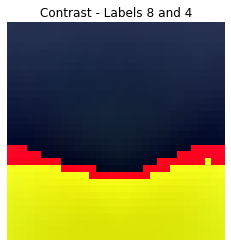

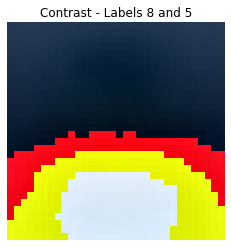

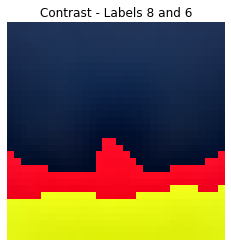

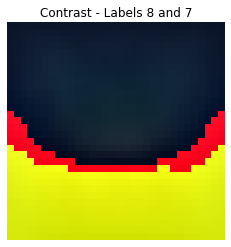

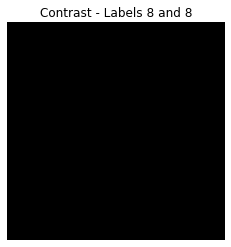

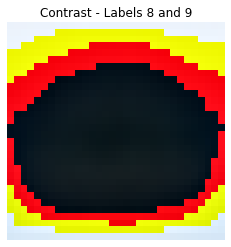

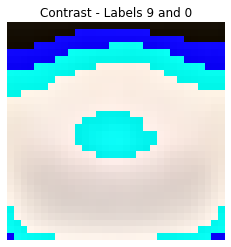

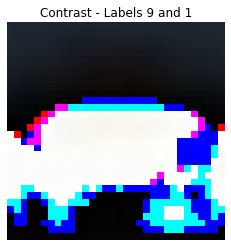

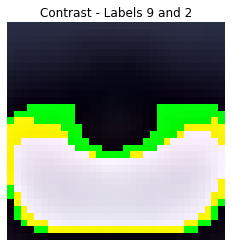

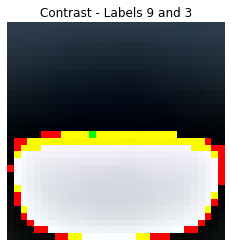

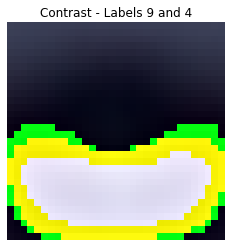

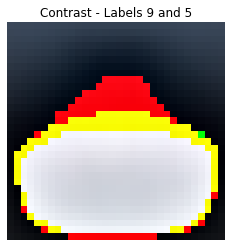

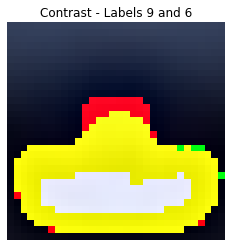

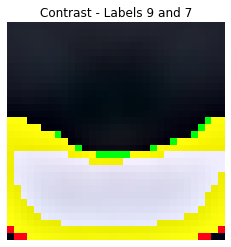

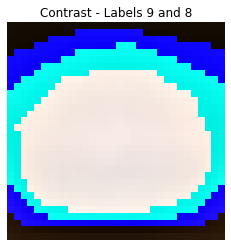

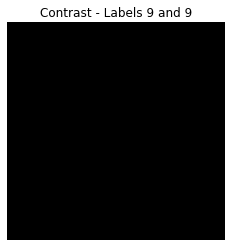

In [59]:
contrast_images = {}
for label_a, mean_image_a in mean_train_images.items():
    for label_b, mean_image_b in mean_train_images.items():
        key = f'{label_a} and {label_b}'
        contrast_images[key] = mean_image_a - mean_image_b

for key, contrast_image in contrast_images.items():
    plt.imshow(contrast_image.astype(np.uint8), cmap='bwr')
    plt.title(f'Contrast - Labels {key}')
    plt.axis('off')
    plt.show()
